2025-01-10 09:09:01.671 | INFO     | FinMind.data.finmind_api:get_data:148 - download Dataset.TaiwanStockInfo, data_id: 
2025-01-10 09:09:11.043 | INFO     | FinMind.data.finmind_api:get_data:148 - download Dataset.TaiwanStockPrice, data_id: 0056
2025-01-10 09:09:16.678 | INFO     | FinMind.data.finmind_api:get_data:148 - download Dataset.TaiwanStockDividend, data_id: 0056
/home/raul/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
2025-01-10 09:09:19.019 | INFO     | FinMind.data.finmind_api:get_data:148 - download TaiwanStockPrice, data_id: TAIEX


MeanProfit          27861.253856
MaxLoss            -41848.477971
FinalProfit         58643.515285
MeanProfitPer           5.570000
FinalProfitPer         11.730000
MaxLossPer             -8.370000
AnnualReturnPer         2.240000
AnnualSharpRatio        0.380000
dtype: float64


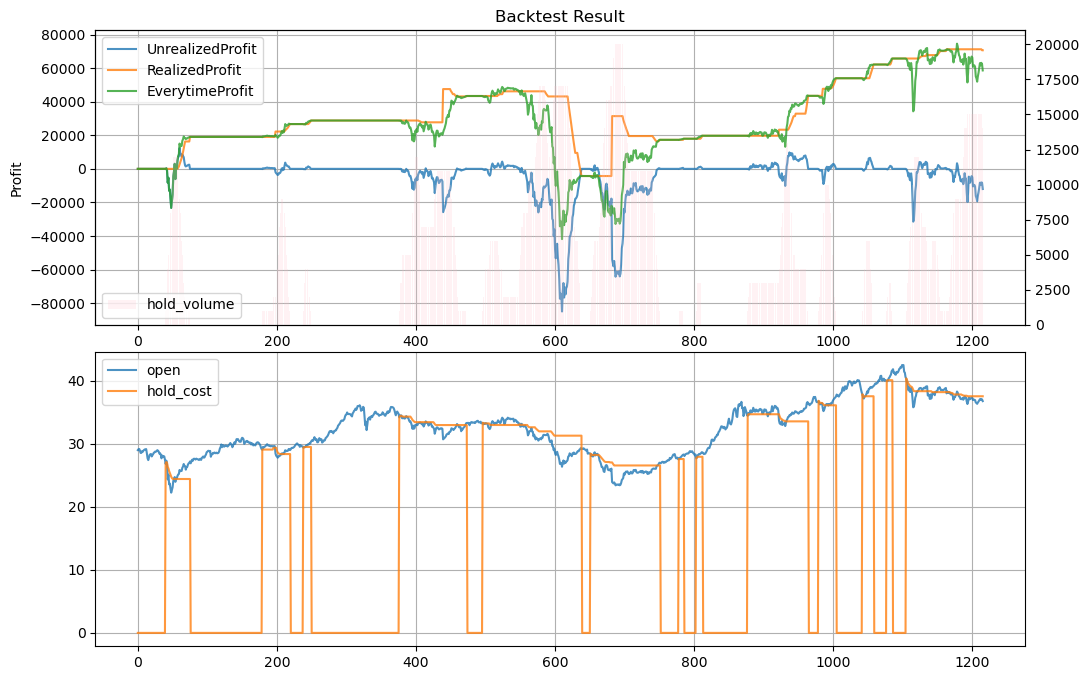

In [2]:
import numpy as np
import pandas as pd
from ta.momentum import StochasticOscillator
from FinMind import strategies
from FinMind.data import DataLoader
from FinMind.strategies.base import Strategy

class Kd2(Strategy):
    """
    url: "https://www.mirrormedia.mg/story/20180719fin012/"
    summary:
        網路上常見的 kd 交易策略
        日KD 80 20
        日K線 <= 20 進場
        日K線 >= 80 出場
    """

    k_days = 9
    kd_upper = 80
    kd_lower = 30

    def setup(slef, k_days=9, kd_upper=80, kd_lower=30):
        self.k_days = k_days
        self.kd_upper = kd_upper
        self.kd_lower = kd_lower

    def create_trade_sign(self, stock_price: pd.DataFrame, additional_dataset_obj) -> pd.DataFrame:
        stock_price = stock_price.sort_values("date")
        kd = StochasticOscillator(
            high=stock_price["max"],
            low=stock_price["min"],
            close=stock_price["close"],
            n=self.k_days,
        )
        rsv_ = kd.stoch().fillna(50)
        _k = np.zeros(stock_price.shape[0])
        _d = np.zeros(stock_price.shape[0])
        for i, r in enumerate(rsv_):
            if i == 0:
                _k[i] = 50
                _d[i] = 50
            else:
                _k[i] = _k[i - 1] * 2 / 3 + r / 3
                _d[i] = _d[i - 1] * 2 / 3 + _k[i] / 3

        stock_price["K"] = _k
        stock_price["D"] = _d
        stock_price.index = range(len(stock_price))
        stock_price["signal"] = 0
        stock_price.loc[stock_price["K"] <= self.kd_lower, "signal"] = 1
        stock_price.loc[stock_price["K"] >= self.kd_upper, "signal"] = -1
        return stock_price
        
data_loader = DataLoader()
# data_loader.login(user_id, password) # 可選
obj = strategies.BackTest(
     stock_id="0056",
     start_date="2020-01-01",
     end_date="2025-01-01",
     trader_fund=500000.0,
     fee=0.001425,
     data_loader=data_loader,
)

obj.add_strategy(Kd2)
obj.simulate()

# 回測詳細資料
trade_detail = obj.trade_detail

# 大盤累積報酬和回測累積報酬走勢
compare_market_detail = obj.compare_market_detail

# 回測結果，包含總報酬(FinalProfitPer)、年化報酬(AnnualReturnPer)、最大損失(MaxLoss)、最大損失比例(MaxLossPer)...等
final_stats = obj.final_stats

# 大盤年化報酬率和策略年化報酬率
compare_market_stats = obj.compare_market_stats

print(final_stats)

obj.plot()